In [20]:
import ast
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.manifold import TSNE
import ast
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing  import StandardScaler, LabelEncoder
from sklearn.metrics        import accuracy_score
import matplotlib.cm as cm

plt.close('all')

In [2]:
strategies = [axl.Cooperator(), axl.Defector(), axl.Grudger()]
strategy_order = [player.__class__.__name__ for player in strategies]
strategy_mapping = {name: player.__class__ for name, player in zip(strategy_order, strategies)}
print("Strategy Mapping:")
print(strategy_mapping)

Strategy Mapping:
{'Cooperator': <class 'axelrod.strategies.cooperator.Cooperator'>, 'Defector': <class 'axelrod.strategies.defector.Defector'>, 'Grudger': <class 'axelrod.strategies.grudger.Grudger'>}


In [3]:
df_experiments = pd.read_csv("../simulated_data/simulated_tournamets/clusterization_framework_data.csv")

In [4]:
df_experiments

,Unnamed: 0,composition,coop_rate,winning_strategy
0,0,"[3, 9, 0]",50.000000,['Defector']
1,1,"[6, 8, 2]",87.562500,['Defector']
2,2,"[0, 7, 15]",93.192149,['Grudger']
3,3,"[0, 1, 1]",50.250000,['Defector']
4,4,"[5, 9, 9]",91.268431,['Grudger']
...,...,...,...,...
295,295,"[5, 1, 8]",177.591837,['Grudger']
296,296,"[6, 2, 2]",152.040000,['Defector']
297,297,"[13, 1, 14]",189.303571,['Defector']
298,298,"[6, 14, 2]",61.214876,['Defector']


In [5]:
df_experiments['winning_strategy'] = df_experiments['winning_strategy'].apply(ast.literal_eval)


In [6]:
df_experiments

,Unnamed: 0,composition,coop_rate,winning_strategy
0,0,"[3, 9, 0]",50.000000,[Defector]
1,1,"[6, 8, 2]",87.562500,[Defector]
2,2,"[0, 7, 15]",93.192149,[Grudger]
3,3,"[0, 1, 1]",50.250000,[Defector]
4,4,"[5, 9, 9]",91.268431,[Grudger]
...,...,...,...,...
295,295,"[5, 1, 8]",177.591837,[Grudger]
296,296,"[6, 2, 2]",152.040000,[Defector]
297,297,"[13, 1, 14]",189.303571,[Defector]
298,298,"[6, 14, 2]",61.214876,[Defector]


In [7]:
SMPI_PATH = "../simulated_data/precalculated_metrics/smpi_data_clusterization.csv"

df_long = pd.read_csv(SMPI_PATH)

In [8]:
def to_count_array(x):
    if isinstance(x, str):
        x = ast.literal_eval(x)          
    return np.asarray(x, dtype=int).ravel()


cpi_lookup = {}

for _, r in df_long.iterrows():
    i, j, val = r["row"], r["col"], r["CPI"]
    cpi_lookup[(i, j)] = val
    cpi_lookup[(j, i)] = val
    if i == j:
        continue

for s in strategy_order:
    cpi_lookup.setdefault((s, s), 0.0)  


def build_eff_cpi(row):
    counts = to_count_array(row["composition"])
    eff    = []
    for i, s_i in enumerate(strategy_order):
        for j, s_j in enumerate(strategy_order[i:]):
            c1, c2  = counts[i], counts[j]
            n_inter = c1*(c1-1)//2 if i == j else c1*c2
            cpi_val = cpi_lookup.get((s_i, s_j), 0.0)
            eff.append(n_inter * cpi_val)
    return np.array(eff)


eff_cpi_mat = np.vstack(df_experiments.apply(build_eff_cpi, axis=1))

eff_cols = [f"EffCPI_{i}{j}"
            for i in range(len(strategy_order))
            for j in range(i, len(strategy_order))]

df_final = pd.concat(
    [df_experiments.reset_index(drop=True),
     pd.DataFrame(eff_cpi_mat, columns=eff_cols)],
    axis=1
)

print("Added columns:", eff_cols[:3], "…", eff_cols[-3:])
print(df_final.head(3))


Added columns: ['EffCPI_00', 'EffCPI_01', 'EffCPI_02'] … ['EffCPI_11', 'EffCPI_12', 'EffCPI_22']
   Unnamed: 0 composition  coop_rate winning_strategy  EffCPI_00  EffCPI_01  \
0           0   [3, 9, 0]  50.000000       [Defector]        0.9      22.95   
1           1   [6, 8, 2]  87.562500       [Defector]        4.5      40.80   
2           2  [0, 7, 15]  93.192149        [Grudger]        0.0       0.00   

   EffCPI_02  EffCPI_11  EffCPI_12  EffCPI_22  
0        0.0        0.0  -0.285655        0.0  
1        3.6        0.0  -0.222176        3.6  
2        0.0        0.0  -0.166632        0.0  


In [9]:
print(cpi_lookup)

{('Cooperator', 'Cooperator'): 0.3, ('Cooperator', 'Defector'): 0.84999999986, ('Defector', 'Cooperator'): 0.84999999986, ('Cooperator', 'Grudger'): 0.3, ('Grudger', 'Cooperator'): 0.3, ('Defector', 'Defector'): 0.0, ('Defector', 'Grudger'): -0.0079348635192631, ('Grudger', 'Defector'): -0.0079348635192631, ('Grudger', 'Grudger'): 0.3}


In [10]:
def weighted_mean_cpi(row):
    counts = to_count_array(row["composition"])
    num, denom = 0.0, 0.0
    for i, s_i in enumerate(strategy_order):
        for j, s_j in enumerate(strategy_order):
            w = counts[i] * counts[j]
                      # interaction weight
            num   += w * cpi_lookup[(s_i, s_j)]
            denom += w
    return num / denom if denom else 0.0       # safe-guard zero

df_final["WMeanCPI"] = df_final.apply(weighted_mean_cpi, axis=1)

In [11]:
df_final['composition'] = df_final['composition'].apply(to_count_array)

In [12]:
counts_mat = np.vstack(df_final["composition"].values)          
coop_rate  = df_final["coop_rate"].values.reshape(-1, 1)       

cpi_cols   = [c for c in df_final.columns if c.startswith("EffCPI_")]
cpi_mat    = df_final[cpi_cols].values                          

wmean_cpi  = df_final["WMeanCPI"].values.reshape(-1, 1)          

X_feat = np.hstack([counts_mat, coop_rate, cpi_mat, wmean_cpi])
print("X_feat shape with WMeanCPI:", X_feat.shape)


X_feat shape with WMeanCPI: (300, 11)


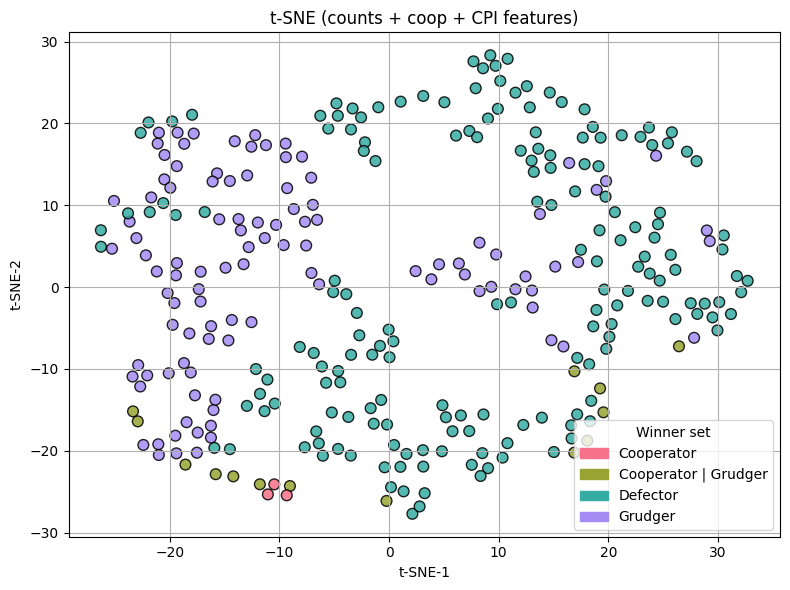

In [13]:

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

tsne = TSNE(n_components=2,
            perplexity=max(5, int(np.sqrt(len(X_scaled)))),
            init="pca",
            learning_rate="auto",
            random_state=42)
X_tsne = tsne.fit_transform(X_scaled)




df_final["winner_set_key"] = df_final["winning_strategy"].apply(
    lambda lst: frozenset(lst) if isinstance(lst, list) else frozenset()
)

unique_sets = sorted(df_final["winner_set_key"].unique(),
                     key=lambda s: tuple(sorted(s)))       

palette     = sns.color_palette("husl", n_colors=len(unique_sets))
set2color   = {w_set: palette[i] for i, w_set in enumerate(unique_sets)}

point_colors = df_final["winner_set_key"].map(set2color).tolist()


plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1],
            c=point_colors, s=60, edgecolor="k", alpha=0.85)
plt.title("t-SNE (counts + coop + CPI features)")
plt.xlabel("t-SNE-1");  plt.ylabel("t-SNE-2");  plt.grid(True)

def set_to_label(fs):
    return " | ".join(sorted(fs)) if fs else "None"

handles = [
    mpatches.Patch(color=set2color[w_set], label=set_to_label(w_set))
    for w_set in unique_sets
]
plt.legend(handles=handles, title="Winner set", loc="best")

plt.tight_layout(); plt.show()

In [14]:
pca2   = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_feat)

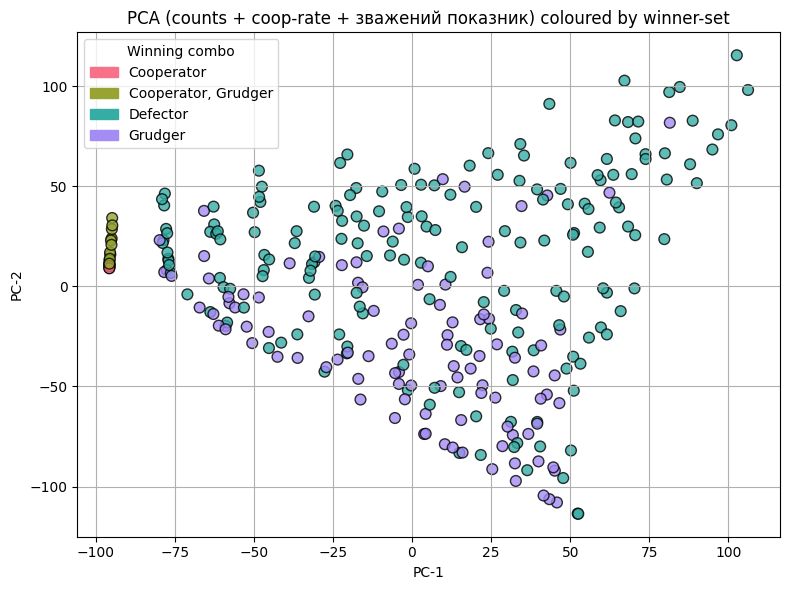

In [15]:

df_final["winner_set_key"] = df_final["winning_strategy"].apply(
    lambda lst: frozenset(lst) if isinstance(lst, list) else frozenset()
)

unique_sets = sorted(df_final["winner_set_key"].unique(),
                     key=lambda s: tuple(sorted(s)))        

palette     = sns.color_palette("husl", n_colors=len(unique_sets))
set2color   = {w_set: palette[i] for i, w_set in enumerate(unique_sets)}

point_colors = df_final["winner_set_key"].map(set2color).tolist()
plt.figure(figsize=(8, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1],
            c=point_colors, s=60, edgecolor="k", alpha=0.8)

plt.title("PCA (counts + coop-rate + зважений показник) coloured by winner-set")
plt.xlabel("PC-1"); plt.ylabel("PC-2"); plt.grid(True)

handles = [mpatches.Patch(color=col,
                          label=", ".join(sorted(w_set)) if w_set else "None")
           for w_set, col in set2color.items()]
plt.legend(handles=handles, title="Winning combo", loc="best")

plt.tight_layout(); plt.show()

In [21]:
LABEL_COL = "winning_strategy"     

def label_to_str(x):
    if isinstance(x, (list, tuple, set, frozenset)):
        return "|".join(sorted(map(str, x)))
    return x
mask     = df_final[LABEL_COL].notna()         
X_all    = X_pca2[mask]                       
y_str    = df_final.loc[mask, LABEL_COL].apply(label_to_str)

unique_strategies = sorted(
    {s for winners in df_final[LABEL_COL]          # LABEL_COL == "winning_strategy" (or whatever you use)
     for s in (winners if isinstance(winners, (list, tuple, set)) else [winners])}
)

cmap   = cm.get_cmap("viridis", len(unique_strategies))
colors = {s: cmap(i) for i, s in enumerate(unique_strategies)}

le       = LabelEncoder()
y_all    = le.fit_transform(y_str)      
print("Classes:", le.classes_)

Classes: ['Cooperator' 'Cooperator|Grudger' 'Defector' 'Grudger']


/var/folders/nw/pb0znbfj0r3288jhzshl4c8h0000gn/T/ipykernel_70757/276821873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap   = cm.get_cmap("viridis", len(unique_strategies))


In [22]:
default_color = (0.5, 0.5, 0.5, 1.0)


In [23]:
label2rgba = {lab: colors.get(lab, default_color) for lab in le.classes_}
point_rgba = np.array([label2rgba[lbl] for lbl in y_str])


In [24]:
X_tr, X_te, y_tr, y_te, rgba_tr, rgba_te = train_test_split(
    X_all, y_all, point_rgba, test_size=0.25, random_state=42, stratify=y_all
)

In [25]:
scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_te_sc = scaler.transform(X_te)

mlp = MLPClassifier(hidden_layer_sizes=(50,),
                    activation="relu",
                    max_iter=10_000,
                    random_state=42)
mlp.fit(X_tr_sc, y_tr)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=10000, random_state=42)

In [26]:
y_pred = mlp.predict(X_te_sc)
print("Accuracy  :", accuracy_score(y_te, y_pred))

Accuracy  : 0.6666666666666666


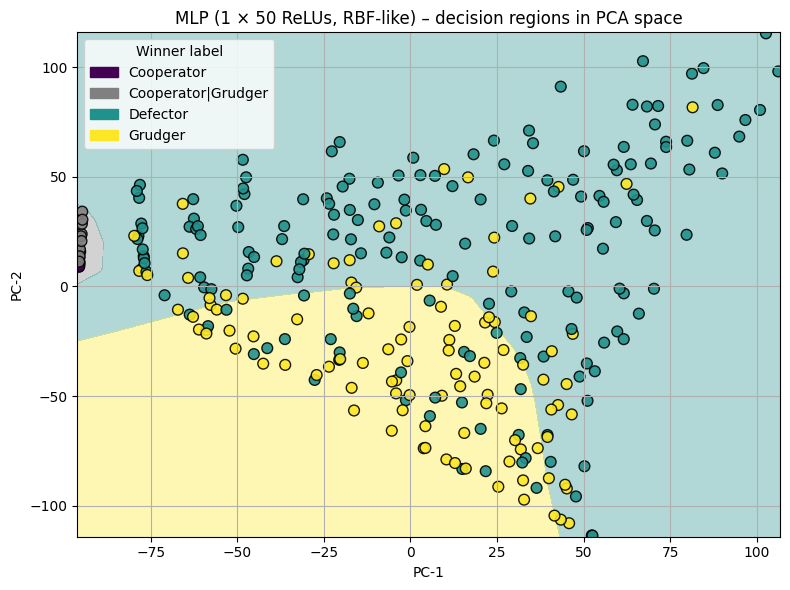

In [27]:
h   = 0.05                         
xlo, xhi = X_all[:, 0].min() - .5, X_all[:, 0].max() + .5
ylo, yhi = X_all[:, 1].min() - .5, X_all[:, 1].max() + .5

xs = np.arange(xlo, xhi, h, dtype=np.float32)
ys = np.arange(ylo, yhi, h, dtype=np.float32)
xx, yy = np.meshgrid(xs, ys)
grid   = np.c_[xx.ravel(), yy.ravel()] 

def batch_predict(model, data, batch=8_192):
    out = np.empty(data.shape[0], dtype=np.int32)
    for i in range(0, len(data), batch):
        out[i:i+batch] = model.predict(data[i:i+batch])
    return out

grid_sc = scaler.transform(grid).astype(np.float32)
Z_int   = batch_predict(mlp, grid_sc, batch=8_192)
Z       = Z_int.reshape(xx.shape)
label2rgba = {lab: colors.get(lab, default_color) for lab in le.classes_}
cmap_list  = [label2rgba[lab] for lab in le.classes_]

plt.figure(figsize=(8, 6))

plt.contourf(xx, yy, Z,
             levels=np.arange(len(le.classes_)+1)-0.5,
             colors=cmap_list, alpha=0.35)

plt.scatter(X_all[:, 0], X_all[:, 1],
            c=point_rgba, edgecolor="k", s=60, alpha=0.9)

plt.title("MLP (1 × 50 ReLUs, RBF-like) – decision regions in PCA space")
plt.xlabel("PC-1"); plt.ylabel("PC-2"); plt.grid(True)

handles = [mpatches.Patch(color=label2rgba[l], label=l) for l in le.classes_]
plt.legend(handles=handles, title="Winner label", loc="best")

plt.tight_layout(); plt.show()


In [28]:
LABEL_COL = "winning_strategy"       

def label_to_str(x):
    if isinstance(x, (list, tuple, set, frozenset)):
        return "|".join(sorted(map(str, x)))
    return x
mask     = df_final[LABEL_COL].notna()         
X_all    = X_tsne[mask]                   
y_str    = df_final.loc[mask, LABEL_COL].apply(label_to_str)

le       = LabelEncoder()
y_all    = le.fit_transform(y_str)    
n_class  = len(le.classes_)
print("Classes:", le.classes_)

Classes: ['Cooperator' 'Cooperator|Grudger' 'Defector' 'Grudger']


In [29]:
default_color = (0.5, 0.5, 0.5, 1.0)


In [30]:
label2rgba = {lab: colors.get(lab, default_color) for lab in le.classes_}
point_rgba = np.array([label2rgba[lbl] for lbl in y_str])


In [31]:
X_tr, X_te, y_tr, y_te, rgba_tr, rgba_te = train_test_split(
    X_all, y_all, point_rgba, test_size=0.25, random_state=42, stratify=y_all
)

In [32]:
scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_te_sc = scaler.transform(X_te)

mlp = MLPClassifier(hidden_layer_sizes=(50,),
                    activation="relu",
                    max_iter=10_000,
                    random_state=42)
mlp.fit(X_tr_sc, y_tr)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=10000, random_state=42)

In [33]:
y_pred = mlp.predict(X_te_sc)
print("Accuracy  :", accuracy_score(y_te, y_pred))

Accuracy  : 0.7466666666666667


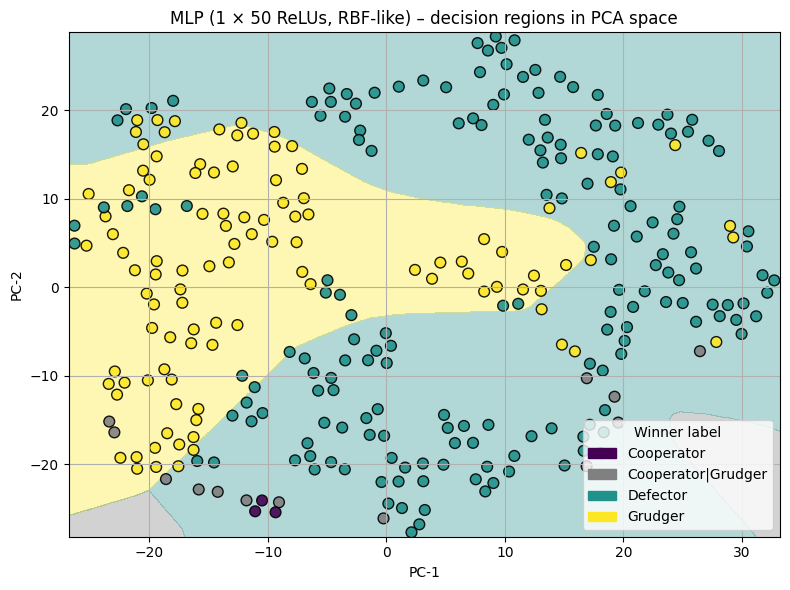

In [34]:
h   = 0.05        
xlo, xhi = X_all[:, 0].min() - .5, X_all[:, 0].max() + .5
ylo, yhi = X_all[:, 1].min() - .5, X_all[:, 1].max() + .5

xs = np.arange(xlo, xhi, h, dtype=np.float32)
ys = np.arange(ylo, yhi, h, dtype=np.float32)
xx, yy = np.meshgrid(xs, ys)
grid   = np.c_[xx.ravel(), yy.ravel()]    

def batch_predict(model, data, batch=8_192):
    out = np.empty(data.shape[0], dtype=np.int32)
    for i in range(0, len(data), batch):
        out[i:i+batch] = model.predict(data[i:i+batch])
    return out

grid_sc = scaler.transform(grid).astype(np.float32)
Z_int   = batch_predict(mlp, grid_sc, batch=8_192)
Z       = Z_int.reshape(xx.shape)


label2rgba = {lab: colors.get(lab, default_color) for lab in le.classes_}
cmap_list  = [label2rgba[lab] for lab in le.classes_]


plt.figure(figsize=(8, 6))

plt.contourf(xx, yy, Z,
             levels=np.arange(len(le.classes_)+1)-0.5,
             colors=cmap_list, alpha=0.35)

plt.scatter(X_all[:, 0], X_all[:, 1],
            c=point_rgba, edgecolor="k", s=60, alpha=0.9)

plt.title("MLP (1 × 50 ReLUs, RBF-like) – decision regions in PCA space")
plt.xlabel("PC-1"); plt.ylabel("PC-2"); plt.grid(True)

handles = [mpatches.Patch(color=label2rgba[l], label=l) for l in le.classes_]
plt.legend(handles=handles, title="Winner label", loc="best")

plt.tight_layout(); plt.show()
